In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
!pip install transformers
import random
import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tqdm.pandas()

device = torch.device('cuda')

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 36.2 MB/s 
     |████████████████████████████████| 7.6 MB 68.5 MB/s 
     |████████████████████████████████| 182 kB 81.1 MB/s 


In [5]:
DF = pd.read_csv('/content/women_balanced.csv',encoding='utf-8',lineterminator='\n')


#DF['label'] = DF['label'].apply(lambda x: x+1)
data = DF[['text','label']]


train_text, test_text, train_labels, test_labels = train_test_split(data[['text']], data[['label']], test_size=0.2, random_state=42)
train_text, val_text, train_labels, val_labels = train_test_split(train_text, train_labels, test_size=0.25, random_state=42)

In [6]:
bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

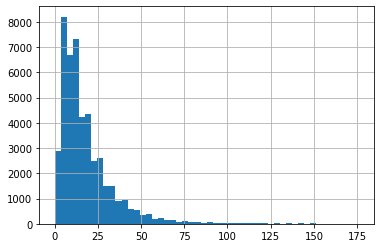

In [7]:
seq_len = [len(str(i).split()) for i in train_text['text']]
pd.Series(seq_len).hist(bins = 50)

In [12]:
train_text = train_text['text'].astype('str')
train_labels = train_labels['label'].astype('int')

val_text = val_text['text'].astype('str')
val_labels = val_labels['label'].astype('int')

test_text = test_text['text'].astype('str')
test_labels = test_labels['label'].astype('int')

In [13]:
tokens_train = tokenizer.batch_encode_plus(
    list(train_text.values),
    max_length = 65,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    list(val_text.values),
    max_length = 65,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    list(test_text.values),
    max_length = 65,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)
batch_size = 32


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

test_data = TensorDataset(test_seq, test_mask)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [14]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,3)
        self.softmax = nn.Softmax(dim = -1)
    
    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [15]:
model = BERT_Arch(bert)

model = model.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_weights)

weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss()
epochs = 3

[1.00844399 0.99194776 0.99974439]


In [17]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
  
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

In [18]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()
            preds = preds.detach().cpu().argmax(axis=1).numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    return avg_loss, total_preds

In [19]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 3


100%|██████████| 489/489 [01:03<00:00,  7.74it/s]



Training loss: 0.936
Validation loss: 0.886

 Epoch2 / 3


100%|██████████| 489/489 [01:03<00:00,  7.71it/s]



Training loss: 0.883
Validation loss: 0.874

 Epoch3 / 3


100%|██████████| 489/489 [01:02<00:00,  7.78it/s]



Training loss: 0.873
Validation loss: 0.867


In [20]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [30]:
import gc
from datetime import timedelta
import time
import sklearn.metrics

gc.collect()
torch.cuda.empty_cache()

list_seq = np.array_split(test_seq, 50)
list_mask = np.array_split(test_mask, 50)
start = time.time()

predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().argmax(axis=1).numpy())

In [31]:
flat_preds = []
for i in predictions:
  for j in i:
    flat_preds.append(j)

data_label = test_labels.to_list()
print(classification_report(test_labels ,flat_preds))

              precision    recall  f1-score   support

           0       0.57      0.54      0.55      5182
           1       0.77      0.79      0.78      5237
           2       0.67      0.69      0.68      5227

    accuracy                           0.67     15646
   macro avg       0.67      0.67      0.67     15646
weighted avg       0.67      0.67      0.67     15646

